In [1]:
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# vossut function translated from matlab code in Schiff, ch 5, p.110

def voss_unscented_transform(p,xhat,Pxx,noisy_data,fct,obsfct,dims_params,dims_augmented_state,
           dims_observations,R):
    
    Pxx = symmetrize(Pxx)
    
    Xa = generate_sigma_points(xhat,Pxx)
    X = fct(p,dims_params,Xa)
    Y = obsfct(p,X).reshape(1,-1)
    
    Pxx = symmetrize(covariance(X,X))
    Pyy = covariance(Y,Y) + R
    Pxy = covariance(X,Y)
        
    K = np.matmul(Pxy,la.inv(Pyy))
    xhat = np.mean(X,1) + np.matmul(K,(noisy_data - np.mean(Y,1)))

    Pxx = symmetrize(Pxx - np.matmul(K,Pxy.T))
    
    return xhat,Pxx,K

def covariance(X,Y):
    '''Calculates biased covariance (or cross covariance) of array-like X and Y'''
    num_samples = len(X[0,:])
    X_centered = mean_center(np.array(X))
    Y_centered = mean_center(np.array(Y))
    return np.matmul(X_centered,Y_centered.T/num_samples)

def mean_center(X):
    '''Centers the mean of rows of X (array-like) around 0.'''
    return np.array([x - np.mean(x) for x in X])

def symmetrize(A):
    '''Numerical safety'''
    return (A + np.transpose(A)) / 2

def generate_sigma_points(xhat,Pxx):
    '''Why have the extra terms from the Cholesky decomp?? Why not just use sigma in each direction?'''
    dims = len(xhat)
    num_sigma_points = 2*dims
    Pxx = symmetrize(Pxx)
    xsigma = la.cholesky(dims*Pxx,lower=True)
    Xa = np.hstack((xsigma,-xsigma))
    for i in range(num_sigma_points):
        Xa[:,i]+=xhat
    return Xa

# RuKu4 integrator
def ruku4(function, state, params, dt, steps, noise):
    noise = state.shape[1]*[noise] if state.ndim == 2 else [noise]
    state += np.array([n*np.random.randn(len(n))*np.sqrt(dt) for n in noise]).reshape(state.shape)
    for i in range(steps):
        k1 = dt*function(state,params)
        k2 = dt*function(state+k1/2,params)
        k3 = dt*function(state+k2/2,params)
        k4 = dt*function(state+k3,params)
        state += k1/6. + k2/3. + k3/3. + k4/6.
    return state

def euler_maruyama(function, state, params, dt, steps, noise):
    noise = state.shape[1]*[noise] if state.ndim == 2 else [noise]
    for i in range(steps):
        state += dt*function(state,params) + np.array([n*np.random.randn(len(n))*np.sqrt(dt) for n in noise]).reshape(state.shape)
    return state

def euler(function, state, params, dt, steps, noise):
    noise = state.shape[1]*[noise] if state.ndim == 2 else [noise]
    for i in range(steps):
        state += dt*function(state,params) 
    return state

def test_integrator(function, state, params, dt, steps, noise):
    noise = state.shape[1]*[noise] if state.ndim == 2 else [noise]
    for i in range(steps):
        state += np.zeros_like(state)
    print('In test_integrator')
    return state



In [3]:
def set_covariances(process_sigmas,observation_sigmas,Pxx0):
    sigmas = {}
    sigmas['Q'] = process_sigmas
    sigmas['R'] = observation_sigmas
    Pxx_init = []
    for n in Pxx0:
        Pxx_init = np.hstack((Pxx_init,sigmas[n]))
    Pxx_init = np.diag(Pxx_init)
    return np.diag(sigmas['Q']), np.diag(sigmas['R']), Pxx_init


# def process_noise(sigmas):
#     return np.diag(sigmas)

# def observation_noise(sigmas=-1, data=np.random.randn(100)):
#     dims = 1 if data.ndim == 1 else data.shape[0]
#     return np.diag(sigmas) if sigmas!=-1 else 0.2*0.2*np.var(data)*np.eye(dims)

In [4]:
def vossFNint(state,parameters):
    '''Fitzhugh-Nagumo model'''
    v, w = state
    input_current = parameters
    input_current = input_current.reshape(v.shape)
    return np.array([c*(w+v-v**3/3+input_current), -(v-a+b*w)/c]);

def vossFNobsfct(augmented_state):
    return augmented_state[-2,:].reshape(1,len(augmented_state[1,:]))

def vossFNfct(dims_params, augmented_state):
    parameters, state = np.split(augmented_state,[dims_params,])
    state = ruku4(vossFNint,state,parameters,dt_integrate,steps_per_sample)
    return np.vstack((parameters,state))
    
def vossFNparams(num_samples):
    global a, b, c, initial_conditions
    a, b, c = 0.7, 0.8, 3.
    initial_conditions = [0., 0.]
    
    Iext = np.arange(1,num_samples+1)/250.*2*np.pi
    Iext = -0.4 - 1.01*(np.abs(np.sin(Iext/2.)))
#     a = 0.7*np.ones_like(Iext)
#     parameters = np.vstack((Iext,a))
    parameters = np.vstack((Iext))
    return parameters.reshape(1,num_samples)


In [5]:
# epileptor parameters; x0 is tracked
def epileptor_parameters(num_samples):
    global y0, tau0, tau1, tau2, Irest1, Irest2, gamma, noise, initial_conditions
    '''x0 is tracked parameter'''
    x0, y0 = -1.6, 1.
    tau0, tau1, tau2 = 2875., 1., 10.
    Irest1, Irest2 = 3.1, 0.45
    gamma = 0.01
    initial_conditions = [0.,-5.,3.,0.,0.,0.]
    noise = [0.025, 0.0, 0., .25, 0., 0.]
    
    time_varying_parameters = x0*np.ones(num_samples)
    return time_varying_parameters.reshape(1,num_samples)

def epileptor_model(state,parameters):
    x1, y1, z, x2, y2, g = state 
    x0 = parameters.reshape(x1.shape)
    x1_dot = y1 - f1(x1,x2,z) - z + Irest1
    y1_dot = y0 - 5.*x1*x1 - y1
    z_dot = 1/tau0*(4*(x1 - x0) - z)
    x2_dot = -y2 + x2 - x2**3 + Irest2 + 2.*g - 0.3*(z - 3.5)
    y2_dot = 1/tau2*(-y2 + f2(x2))
    g_dot = -gamma*(g - 0.1*x1)
    return np.array([x1_dot, y1_dot, z_dot, x2_dot, y2_dot, g_dot])

def epileptor_observation_function(p,augmented_state):
    x1 = augmented_state[p.dims_params,:]
    x2 = augmented_state[p.dims_params+3,:]
    return -x1 + x2

def epileptor_transition_function(p, num_params, augmented_state):
    parameters, state = np.split(augmented_state,[num_params,])
    state = ruku4(epileptor_model,state,parameters,p.dt_integrate,p.steps_per_sample,p.noise)
    return np.vstack((parameters,state))

def f1(x1,x2,z):
    return ( x1**3 - 3*x1**2 ) * (x1 < 0) + ( x1*(x2 - 0.6*(z-4)**2) ) * (x1 >=0)

def f2(x2):
    return 0 * (x2 < -0.25) + ( 6*(x2 + 0.25) ) * (x2 >= -0.25)


In [63]:
# Set parameters for simulation and filtering

model_function = epileptor_model
transition_function = epileptor_transition_function
observation_function = epileptor_observation_function
parameter_function = epileptor_parameters

integrator = ruku4

class epileptor_model:
    def __init__(self):
        self._model = 'epileptor'
        
    def get_num_samples(self,time,dt):
        return int(time//dt)
    
    def get_steps_per_sample(self,dt_sample,dt_integrate):
        return int(dt_sample//dt_integrate)
    
#     def observation_function(self,augmented_state):
#         return epileptor_observation_function(self,augmented_state)
        
    var_names = ['x1','y1','z','x2','y2','g']
    parameter_names = ['x0']

    dims_params = 1
    dims_state_vars = 6
    dims_observations = 1
    dims_augmented_state = dims_params + dims_state_vars

    noise = [0.025, 0., 0., 0.25, 0., 0.]

    process_sigmas = [0.015]
    observation_sigmas = [] # empty array will use sim data to generate observation_sigmas
    Pxx0 = 'QRRRRRR'

    total_time = 10 # 2500 for epileptor, 160 for FN
    dt_sample = 0.1
    dt_integrate = dt_sample
    
    num_samples = get_num_samples([],total_time,dt_sample)
    steps_per_sample = get_steps_per_sample([],dt_sample,dt_integrate)

#     parameters = parameter_function(num_samples).reshape(dims_params,num_samples)
#     def epileptor_parameters(num_samples):
#     global y0, tau0, tau1, tau2, Irest1, Irest2, gamma, noise, initial_conditions

    '''x0 is tracked parameter'''
    x0, y0 = -1.6, 1.
    tau0, tau1, tau2 = 2875., 1., 10.
    Irest1, Irest2 = 3.1, 0.45
    gamma = 0.01
    initial_conditions = [0.,-5.,3.,0.,0.,0.]
    noise = [0.025, 0.0, 0., .25, 0., 0.]
    
    x0_parameter = (x0*np.ones(num_samples)).reshape(1,num_samples)
    parameters = x0_parameter

    integrator = 'ruku4'
    
    def fix_integration_parameters(self): 
#         self.num_samples = int(self.total_time//self.dt_sample)
        self.num_samples = self.get_num_samples(self.total_time,self.dt_sample)
        self.x0_parameter = (self.x0*np.ones(self.num_samples)).reshape(1,self.num_samples)
        self.parameters = self.x0_parameter
        self.steps_per_sample = self.get_steps_per_sample(self.dt_sample,self.dt_integrate)

    def integrate(self,state,params):
        switcher = {
            'ruku4': ruku4,
            'euler': euler,
            'euler_maruyama': euler_maruyama,
            'test_integrator': test_integrator
        }
        return switcher[self.integrator](self.model_function,state,params,
                          self.dt_integrate,self.steps_per_sample,self.noise)
    
    def model_function(self,state,parameters):
        x1, y1, z, x2, y2, g = state 
        x0 = parameters.reshape(x1.shape)
        x1_dot = y1 - self.f1(x1,x2,z) - z + self.Irest1
        y1_dot = self.y0 - 5.*x1*x1 - y1
        z_dot = 1/self.tau0*(4*(x1 - x0) - z)
        x2_dot = -y2 + x2 - x2**3 + self.Irest2 + 2.*g - 0.3*(z - 3.5)
        y2_dot = 1/self.tau2*(-y2 + self.f2(x2))
        g_dot = -self.gamma*(g - 0.1*x1)
        return np.array([x1_dot, y1_dot, z_dot, x2_dot, y2_dot, g_dot])
    
    def observation_function(self,augmented_state):
        x1 = augmented_state[self.dims_params,:]
        x2 = augmented_state[self.dims_params+3,:]
        return -x1 + x2

    def transition_function(self, augmented_state):
        parameters, state = np.split(augmented_state,[self.dims_params,])
        state = ruku4(epileptor_model,state,parameters,self.dt_integrate,
                      self.steps_per_sample,self.noise)
        return np.vstack((parameters,state))

    def f1(self,x1,x2,z):
        return ( x1**3 - 3*x1**2 ) * (x1 < 0) + ( x1*(x2 - 0.6*(z-4)**2) ) * (x1 >=0)

    def f2(self,x2):
        return 0 * (x2 < -0.25) + ( 6*(x2 + 0.25) ) * (x2 >= -0.25)
    
    

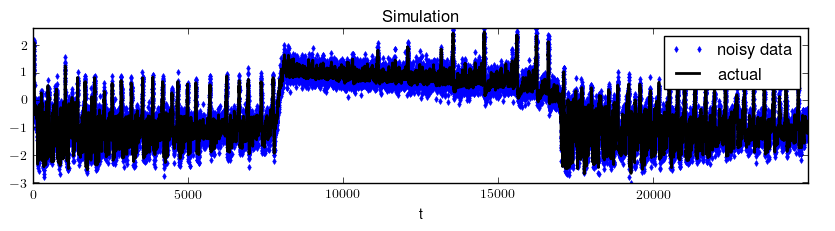

In [66]:
p = epileptor_model()
p.total_time = 2500
p.fix_integration_parameters()
generate_simulation(p)

In [7]:
def unscented_kalman(p=epileptor_model()):
    '''Uses global vars for now'''
    global estimated_state, Pxx, Ks, errors        
    for k in range(1,p.num_samples):
        try:
            estimated_state[:,k],Pxx[:,:,k],Ks[:,:,k] = voss_unscented_transform(p,
                estimated_state[:,k-1],Pxx[:,:,k-1],noisy_data[:,k],
                transition_function,observation_function,p.dims_params,p.dims_augmented_state,
                p.dims_observations, R)
        except la.LinAlgError:
            Pxx[:,:,k-1] = Pxx[:,:,k-2]
            estimated_state[:,k],Pxx[:,:,k],Ks[:,:,k] = voss_unscented_transform(p,
                estimated_state[:,k-1],Pxx[:,:,k-1],noisy_data[:,k],
                transition_function,observation_function,p.dims_params,p.dims_augmented_state,
                p.dims_observations, R)
        if dims_params > 0: Pxx[:p.dims_params,:p.dims_params,k] = Q
        errors[:,k] = np.sqrt(np.diag(Pxx[:,:,k]))
    
        
def print_results(p,augmented_state,estimated_state):
    '''Prints results of Kalman filtering.'''
    results = {}
    results['chisq'] = np.mean(sum((augmented_state - estimated_state)**2))
    results['est'] = estimated_state[:p.dims_params,-1]
    results['error'] = errors[:p.dims_params,-1]
    results['meanest'] = np.mean(estimated_state[:p.dims_params,:],1)
    results['meanerror'] = np.mean(errors[:p.dims_params,:],1)
    for key,value in results.items():
        print('{0:15s}{1}'.format(key+':',str(value)))
    return results

def plot_simulated_data(p=epileptor_model()):
    '''Plot simulation'''
    plt.rc('text', usetex=True)
    plt.figure(figsize=(10,2))
    plt.plot(noisy_data[0,:],'bd',markeredgecolor='blue', mfc='blue',ms=3,label='noisy data');
    plt.plot(observation_function(p,augmented_state).T,'k',linewidth=2,label='actual'); 
    plt.xlabel('t');
    plt.legend();
    plt.axis('tight')
    plt.title('Simulation')
        
def plot_filter_results(p=epileptor_model()):
    '''Plots results of Kalman filtering'''
    plt.rc('text', usetex=True)
    plt.figure(figsize=(10,2))
    for i in range(p.dims_state_vars):
        plt.plot(augmented_state[p.dims_params+i,:],lw=2,label=p.var_names[i])
        plt.plot(estimated_state[p.dims_params+i,:],'r--',lw=2)
    plt.title('Estimated State Variables')
    plt.legend()
    plt.xlabel('t/dt')
    plt.axis('tight')

    plt.figure(figsize=(10,2))
    for i in range(p.dims_params):
        plt.plot(augmented_state[i,:],'k',linewidth=2,label=p.parameter_names[i])
        plt.plot(estimated_state[i,:],'m',linewidth=2)
        plt.plot(estimated_state[i,:] + errors[i,:],'m')
        plt.plot(estimated_state[i,:] - errors[i,:],'m')
    plt.title('Estimated Parameters')
    plt.legend()
    plt.xlabel('t/dt')
    plt.axis('tight')
    plt.show()

In [8]:
# Generate true trajectory 
def integrate_model(p):
    true_state = np.zeros((len(p.initial_conditions),p.num_samples)) # allocate
    true_state[:,0] = p.initial_conditions
    for n in range(p.num_samples-1):
        x_temp = true_state[:,n]
        true_state[:,n+1] = p.integrate(state=x_temp, params=p.parameters[:,n])      
    return true_state

In [9]:
def generate_simulation(p):
    '''
    Simulates true and noisy trajectory based on previously 
    defined model and parameter functions
    (Uses global vars)
    '''
    global observation_sigmas, parameters, augmented_state, Q, R, Pxx, noisy_data
    
    # Simulate model
    true_state = integrate_model(p)
    augmented_state = np.vstack((p.parameters*np.ones((p.dims_params,p.num_samples)),true_state)) if p.dims_params > 0 else true_state
    dims_augmented_state = p.dims_params+p.dims_state_vars
    Pxx = np.zeros((dims_augmented_state,dims_augmented_state,p.num_samples))
    
    # Covariances
    if not p.observation_sigmas:
        p.observation_sigmas = [0.2*0.2*np.var(observation_function(p,augmented_state))]
    Q, R, Pxx[:,:,0] = set_covariances(p.process_sigmas, p.observation_sigmas, p.Pxx0)

    # Create noisy data from true trajectory
    noisy_data = observation_function(p,augmented_state) + np.matmul(la.sqrtm(R),
                                       np.random.randn(p.dims_observations,p.num_samples))

    plot_simulated_data()

99

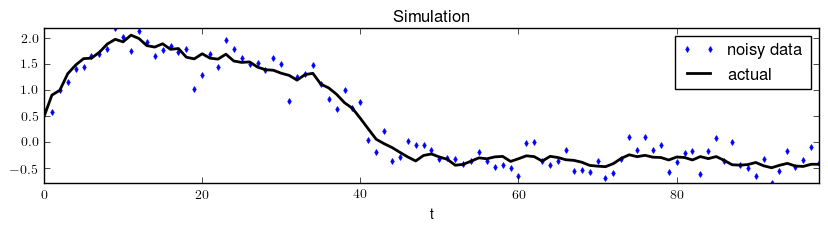

In [33]:
p = epileptor_model()
p.total_time = 2500
generate_simulation(p)
p.num_samples

In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_integrator
In test_inte

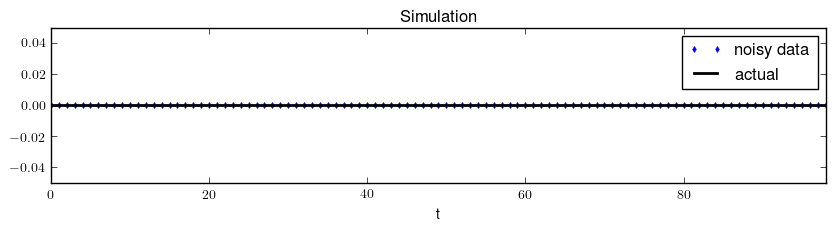

In [29]:
p = epileptor_model()
p.integrator = 'test_integrator'
generate_simulation(p)
print(p.integrator)

In [12]:
# Unscented Kalman Filter
num_samples = p.num_samples
dims_observations = p.dims_observations
dims_params = p.dims_params
dims_augmented_state = p.dims_augmented_state

# Preallocate arrays
estimated_state = np.zeros((dims_augmented_state,num_samples)) # estimated trajectory
errors = np.zeros((dims_augmented_state, num_samples))
Ks = np.zeros((dims_augmented_state,dims_observations,num_samples))

# Initialize estimated state
estimated_state[:,0] = augmented_state[:,0]
# r = 6
# estimated_state[:,0] = -r/2. + np.random.randint(1,r,augmented_state[:,0].shape) + augmented_state[:,0]
# estimated_state[dims_params,0] = noisy_data[0,0]/2.
# estimated_state[dims_params+3,0] = noisy_data[0,0]/2. + estimated_state[dims_params,0]

# Main loop for recursive estimation
unscented_kalman(p)

# Results
print_results(p,augmented_state,estimated_state)

# Plotting
plot_filter_results(p)

TypeError: __init__() takes 1 positional argument but 3 were given

In [ ]:
# Test: mean_center 
A = np.random.randn(3,4)
A0 = mean_center(A)
assert np.allclose(np.mean(A0,1),0)

# Test: symmetrize
A = np.random.randn(3,3)
assert (symmetrize(A) == np.transpose(symmetrize(A))).all()

# Test: covariance
A = np.array(np.random.randn(2,10))
B = np.array(np.random.randn(1,10))
assert np.allclose(covariance(A,A),np.cov(A,bias=True))

# Test: generate_sigma_points
